# Starting with the Analysis:
___
## **1. Understanding Data**
___

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import datetime
import math
from datetime import date
from scipy import stats

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Imbalance Dataset
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# Model Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve

# Modelling Algoritm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import scikitplot as skplt

import warnings
warnings.simplefilter(action='ignore')

In [2]:
SBAdata = pd.read_csv('SBAnational.csv')
SBAdata.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [3]:
SBAdata.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [4]:
SBAdata.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

___
## **2. DATA PREPROCESSING**

### **2.1. Handling Variables**

____

In [5]:
date_col = ['ApprovalDate', 'ChgOffDate','DisbursementDate']
SBAdata[date_col] = pd.to_datetime(SBAdata[date_col].stack(),format='%d-%b-%y').unstack()


SBAdata['ApprovalFY'].replace('1976A', 1976, inplace=True)
SBAdata['ApprovalFY']= SBAdata['ApprovalFY'].astype(int)


curr_col = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
SBAdata[curr_col] = SBAdata[curr_col].replace('[\$,]', '', regex=True).astype(float) 


SBAdata['MIS_Status'] = SBAdata['MIS_Status'].replace({'P I F': 0, 'CHGOFF':1})


SBAdata['LowDoc'] = SBAdata['LowDoc'].replace({'[C, S, A, R, 1, 0]':np.nan})
SBAdata['LowDoc'] = SBAdata['LowDoc'].replace({'N': 0, 'Y':1})
SBAdata['LowDoc'] = np.where((SBAdata['LowDoc'] != 0) & (SBAdata['LowDoc'] != 1), 
                             np.nan, SBAdata.LowDoc)


SBAdata['RevLineCr'] = SBAdata['RevLineCr'].replace({'N': 0, 'Y':1, })
SBAdata['RevLineCr'] = SBAdata['RevLineCr'].replace({'0': 0, '1':1, })
SBAdata['RevLineCr'] = np.where((SBAdata['RevLineCr'] != 0) & (SBAdata['RevLineCr'] != 1), 
                                np.nan, SBAdata.RevLineCr)


SBAdata['NewExist'] = SBAdata['NewExist'].replace({1.0: 0, 2.0:1, 0:np.nan}).fillna(0).astype(int)

In [6]:
SBAdata['FranchiseCode'] = SBAdata['FranchiseCode'].replace(1,0 )
SBAdata['FranchiseCode'] = np.where((SBAdata.FranchiseCode != 0 ), 1, SBAdata.FranchiseCode)

SBAdata.rename(columns={"FranchiseCode": "Is_Franchised"}, inplace=True)

SBAdata['CreateJob'] = np.where((SBAdata.CreateJob > 0 ),1,SBAdata.CreateJob)
SBAdata.rename(columns={"CreateJob": "Is_CreatedJob"}, inplace=True)


SBAdata['RetainedJob'] = np.where((SBAdata.RetainedJob > 0 ),1,SBAdata.RetainedJob)
SBAdata.rename(columns={"RetainedJob": "Is_RetainedJob"}, inplace=True)


SBAdata['RealEstate'] = SBAdata['Term'].apply(lambda x: 1 if x >= 240 else 0)


SBAdata['DaysTerm'] =  SBAdata['Term']*30
SBAdata['Active'] = SBAdata['DisbursementDate'] + pd.TimedeltaIndex(SBAdata['DaysTerm'], unit='D')


startdate = datetime.datetime.strptime('2007-12-1', "%Y-%m-%d").date()
enddate = datetime.datetime.strptime('2009-06-30', "%Y-%m-%d").date()

SBAdata['Recession'] = SBAdata['Active'].apply(lambda x: 1 if startdate <= x <= enddate else 0)

In [7]:
SBAdata.dtypes

LoanNr_ChkDgt                 int64
Name                         object
City                         object
State                        object
Zip                           int64
Bank                         object
BankState                    object
NAICS                         int64
ApprovalDate         datetime64[ns]
ApprovalFY                    int64
Term                          int64
NoEmp                         int64
NewExist                      int64
Is_CreatedJob                 int64
Is_RetainedJob                int64
Is_Franchised                 int64
UrbanRural                    int64
RevLineCr                    object
LowDoc                       object
ChgOffDate           datetime64[ns]
DisbursementDate     datetime64[ns]
DisbursementGross           float64
BalanceGross                float64
MIS_Status                  float64
ChgOffPrinGr                float64
GrAppv                      float64
SBA_Appv                    float64
RealEstate                  

In [8]:
ind_code = SBAdata['NAICS']

def get_code(ind_code):
    if ind_code <= 0:
        return 0
    
    return (ind_code // 10 ** (int(math.log(ind_code, 10)) - 1))


def sector_name(i):
    
    def_code = {11:'Agriculture, Forestry, Fishing & Hunting', 21:'Mining, Quarying, Oil & Gas',
                22:'Utilities', 23:'Constuction', 31:'Manufacturing', 32:'Manufacturing', 33:'Manufacturing',
                42:'Wholesale Trade', 44:'Retail Trade', 45:'Retail Trade', 48:'Transportation & Warehousing',
                49:'Transportation & Warehousing', 51:'Information', 52:'Finance & Insurance', 
                53:'Real Estate, Rental & Leasing', 54:'Professional, Scientific & Technical Service',
                55:'Management of Companies & Enterprise', 
                56:'Administrative, Support, Waste Management & Remediation Service',
                61:'Educational Service', 62:'Health Care & Social Assistance',
                71:'Arts, Entertainment & Recreation', 72:'Accomodation & Food Service',
                81:'Other Servieces (Ex: Public Administration)', 92:'Public Administration'
               }
    
    if i in def_code:
        return def_code[i]
    
def def_rate(i):
    
    sector_default = {21:0.08, 11:0.09, 55:0.10, 
                      62: 0.10, 22:0.14, 
                      92:0.15,54:0.19, 
                      42:0.19,31:0.19,
                      32:0.16,33:0.14,
                      81:0.20,71:0.21,
                      72:0.22,44:0.22,
                      45:0.23,23:0.23,
                      56:0.24,61:0.24,
                      51:0.25,48:0.27,
                      49:0.23,52:0.28,53:0.29}
    
    if i in sector_default:
        return sector_default[i]

    return np.nan

In [9]:
SBAdata['ind_code'] = SBAdata.NAICS.apply(get_code)

SBAdata['Sector_name'] = SBAdata.ind_code.apply(sector_name)

SBAdata['Sector_rate'] = SBAdata.NAICS.apply(get_code).apply(def_rate)

In [10]:
SBAdata[['NAICS','ind_code', 'Sector_rate', 'Sector_name']].head()

,NAICS,ind_code,Sector_rate,Sector_name
0,451120,45,0.23,Retail Trade
1,722410,72,0.22,Accomodation & Food Service
2,621210,62,0.10,Health Care & Social Assistance
3,0,0,NaN,None
4,0,0,NaN,None


In [11]:
def_state = SBAdata.groupby(['State', 'MIS_Status'])['State'].count().unstack('MIS_Status')
def_state['Def_Percent'] = def_state[1]/(def_state[1] + def_state[0])
def_state = def_state.drop(axis=1, columns=[0.0, 1.0]).round(1).to_dict()

def state_def_rate(i):
    def_state = {'AK': 0.1,'AL': 0.2, 'AR': 0.2, 'AZ': 0.2,'CA': 0.2, 'CO': 0.2, 'CT': 0.1, 'DC': 0.2,
                 'DE': 0.2, 'FL': 0.3, 'GA': 0.2, 'HI': 0.2, 'IA': 0.1, 'ID': 0.1, 'IL': 0.2, 'IN': 0.2, 
                 'KS': 0.1, 'KY': 0.2, 'LA': 0.2, 'MA': 0.1, 'MD': 0.2, 'ME': 0.1, 'MI': 0.2, 'MN': 0.1,
                 'MO': 0.2, 'MS': 0.2, 'MT': 0.1, 'NC': 0.2, 'ND': 0.1, 'NE': 0.1, 'NH': 0.1, 'NJ': 0.2,
                 'NM': 0.1, 'NV': 0.2, 'NY': 0.2, 'OH': 0.2, 'OK': 0.2, 'OR': 0.2, 'PA': 0.1, 'RI': 0.1,
                 'SC': 0.2, 'SD': 0.1, 'TN': 0.2, 'TX': 0.2, 'UT': 0.2, 'VA': 0.2, 'VT': 0.1, 'WA': 0.1,
                 'WI': 0.1, 'WV': 0.2, 'WY': 0.1}

    if i in def_state:
        return def_state[i]

In [12]:
SBAdata['State_rate'] = SBAdata.State.apply(state_def_rate)

In [13]:
SBAdata[['State', 'State_rate']].head(10)

,State,State_rate
0,IN,0.2
1,IN,0.2
2,IN,0.2
3,OK,0.2
4,FL,0.3
5,CT,0.1
6,NJ,0.2
7,FL,0.3
8,FL,0.3
9,CT,0.1


In [14]:
SBAdata['Portion_SBA_Bank'] = SBAdata['SBA_Appv']/SBAdata['GrAppv']

In [15]:
SBAdata = SBAdata[SBAdata['DisbursementDate'] <= pd.Timestamp(2010, 12, 31)]

In [16]:
SBAdata.isnull().sum()

LoanNr_ChkDgt             0
Name                     12
City                     30
State                    12
Zip                       0
Bank                   1504
BankState              1511
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
Is_CreatedJob             0
Is_RetainedJob            0
Is_Franchised             0
UrbanRural                0
RevLineCr             19102
LowDoc                 5388
ChgOffDate           715964
DisbursementDate          0
DisbursementGross         0
BalanceGross              0
MIS_Status             1775
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
RealEstate                0
DaysTerm                  0
Active                    0
Recession                 0
ind_code                  0
Sector_name          201530
Sector_rate          201530
State_rate               12
Portion_SBA_Bank    

___
### **2.2. Handling Missing Variables**
___

In [17]:
SBAdata[['NewExist', 'Is_Franchised']].head(10)

,NewExist,Is_Franchised
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0
5,0,0
6,1,0
7,1,0
8,1,0
9,1,0


In [18]:
SBAdata['LowDoc'] = np.where((SBAdata['LowDoc'] == np.nan) & (SBAdata['DisbursementGross'] < 150000),
                             1, 
                             SBAdata.LowDoc)

SBAdata['LowDoc'] = np.where((SBAdata['LowDoc'] == np.nan) & (SBAdata['DisbursementGross'] >= 150000),
                             0,
                             SBAdata.LowDoc)

SBAdata = SBAdata[(SBAdata['LowDoc'] == 0) | (SBAdata['LowDoc'] == 1)]

In [19]:
SBAdata.LowDoc.value_counts()

0    761337
1    110300
Name: LowDoc, dtype: int64

In [20]:
SBAdata['MIS_Status'] = np.where((SBAdata['MIS_Status'] == 0.0) & (SBAdata['ChgOffDate'] == np.nan),
                                 0,
                                 SBAdata.MIS_Status)
SBAdata['MIS_Status'] = np.where((SBAdata['MIS_Status'] == 1.0) & (SBAdata['ChgOffDate'] != np.nan),
                                 1,
                                 SBAdata.MIS_Status)

SBAdata = SBAdata[(SBAdata['MIS_Status'] == 0) | (SBAdata['MIS_Status'] == 1)]

In [21]:
SBAdata.MIS_Status.value_counts()

0.0    715314
1.0    154552
Name: MIS_Status, dtype: int64

In [22]:
SBAdata = SBAdata.drop(axis=1, columns=['Name','Bank','NAICS', 'BankState',
                                  'ChgOffDate','ind_code', 'Active', 'DaysTerm'])

In [23]:
SBAdata.dropna(subset=['City', 'State','LowDoc', 'MIS_Status', 
                    'Sector_rate', 'Sector_name', 'RevLineCr'], inplace=True)

In [24]:
SBAdata.isnull().sum()

LoanNr_ChkDgt        0
City                 0
State                0
Zip                  0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
Is_CreatedJob        0
Is_RetainedJob       0
Is_Franchised        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
RealEstate           0
Recession            0
Sector_name          0
Sector_rate          0
State_rate           0
Portion_SBA_Bank     0
dtype: int64

In [25]:
SBAdata.shape

(653377, 28)

___
### **2.3 Data Exploration**
___

In [26]:
SBAdata = SBAdata.astype({'UrbanRural': 'object', 
                    'RevLineCr': 'int64', 
                    'LowDoc':'int64', 
                    'MIS_Status':'int64'})

Text(0, 0.5, 'Loan Amount ($)')

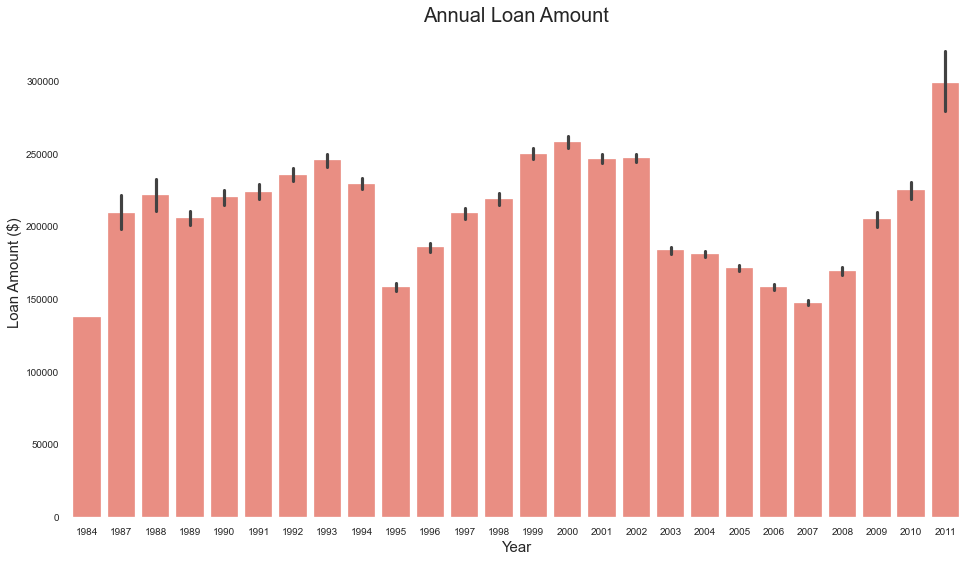

In [27]:
f, ax = plt.subplots(figsize=(16,9))

sns.barplot(x = "ApprovalFY", 
            y = "DisbursementGross", 
            color = 'Salmon', 
            data = SBAdata)

plt.title('Annual Loan Amount', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Loan Amount ($)', fontsize=15)


In [28]:
SBAdata.DisbursementGross.describe()

count    6.533770e+05
mean     1.934851e+05
std      2.842418e+05
min      4.000000e+03
25%      3.750000e+04
50%      9.200000e+04
75%      2.200000e+05
max      1.144632e+07
Name: DisbursementGross, dtype: float64

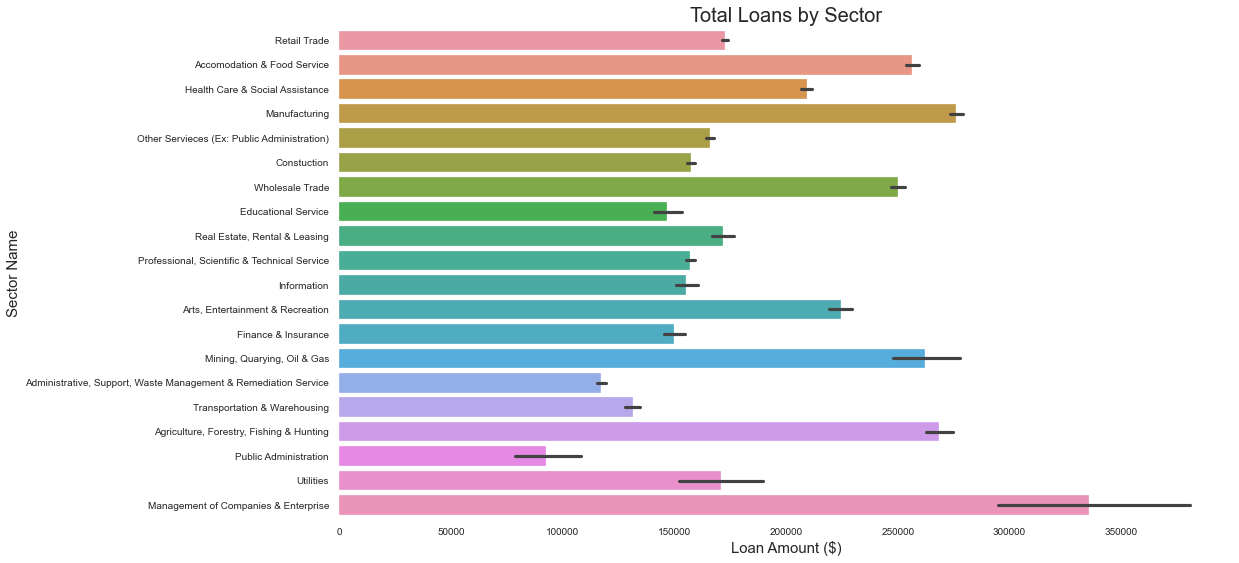

In [29]:
f, ax = plt.subplots(figsize=(16,9))

sns.barplot(x = "DisbursementGross", 
            y = "Sector_name", 
            data = SBAdata)

plt.title('Total Loans by Sector', fontsize=20)
plt.xlabel('Loan Amount ($)', fontsize=15)
plt.ylabel('Sector Name', fontsize=15)
plt.show()

In [30]:
SBAdata.groupby('Sector_name')['DisbursementGross'].describe().style.highlight_max(
    color = 'violet'
).highlight_min(color = 'yellow')

,count,mean,std,min,25%,50%,75%,max
Sector_name,,,,,,,,
Accomodation & Food Service,64059.000000,256482.361136,354045.191225,4000.000000,50000.000000,130000.000000,285000.000000,5000000.000000
"Administrative, Support, Waste Management & Remediation Service",30189.000000,117252.122197,197300.466515,4000.000000,25000.000000,50000.000000,125000.000000,4656672.000000
"Agriculture, Forestry, Fishing & Hunting",8404.000000,268416.790814,288049.823996,4700.000000,60000.000000,168600.000000,384021.000000,2929780.000000
"Arts, Entertainment & Recreation",13808.000000,224344.170915,317524.797379,4000.000000,36909.250000,100000.000000,260000.000000,4426492.000000
Constuction,61622.000000,157278.581919,238484.059452,4000.000000,35000.000000,75000.000000,173682.500000,5658120.000000
Educational Service,5957.000000,146829.699513,251079.800795,4000.000000,25000.000000,52300.000000,150000.000000,2653000.000000
Finance & Insurance,8843.000000,149866.275020,235985.677122,4000.000000,30000.000000,66000.000000,150000.000000,2500000.000000
Health Care & Social Assistance,52021.000000,209244.256723,276016.311572,4000.000000,50000.000000,105000.000000,250000.000000,4000000.000000
Information,10634.000000,155157.020406,263323.367122,4024.000000,24100.000000,56933.000000,150000.000000,2200000.000000


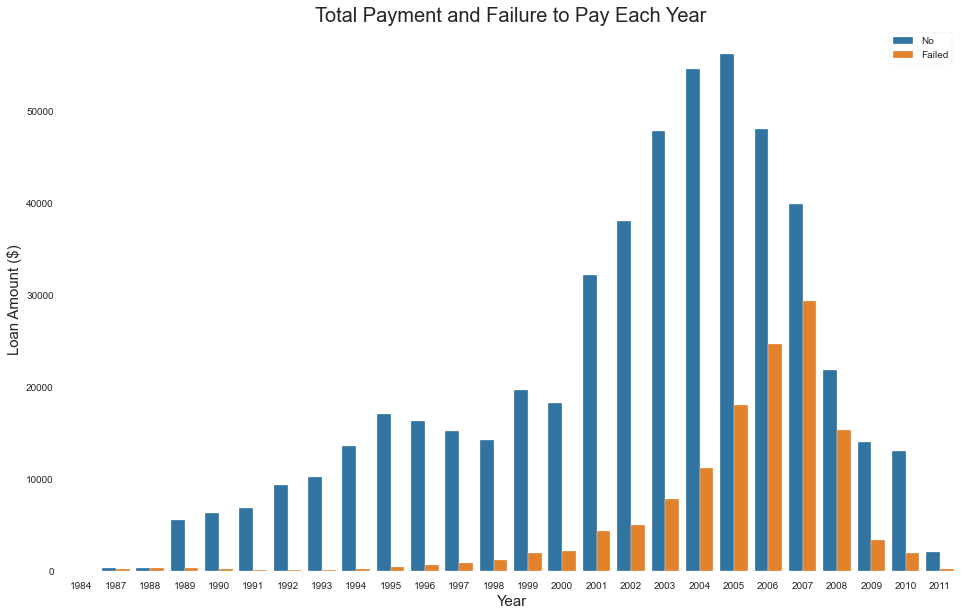

In [31]:
f, ax = plt.subplots(figsize=(16,10))

sns.countplot(x="ApprovalFY", data = SBAdata, hue = 'MIS_Status')

plt.title('Total Payment and Failure to Pay Each Year', fontsize=20)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Loan Amount ($)', fontsize=15)
plt.legend(["No", "Failed"],loc='upper right')
plt.show()

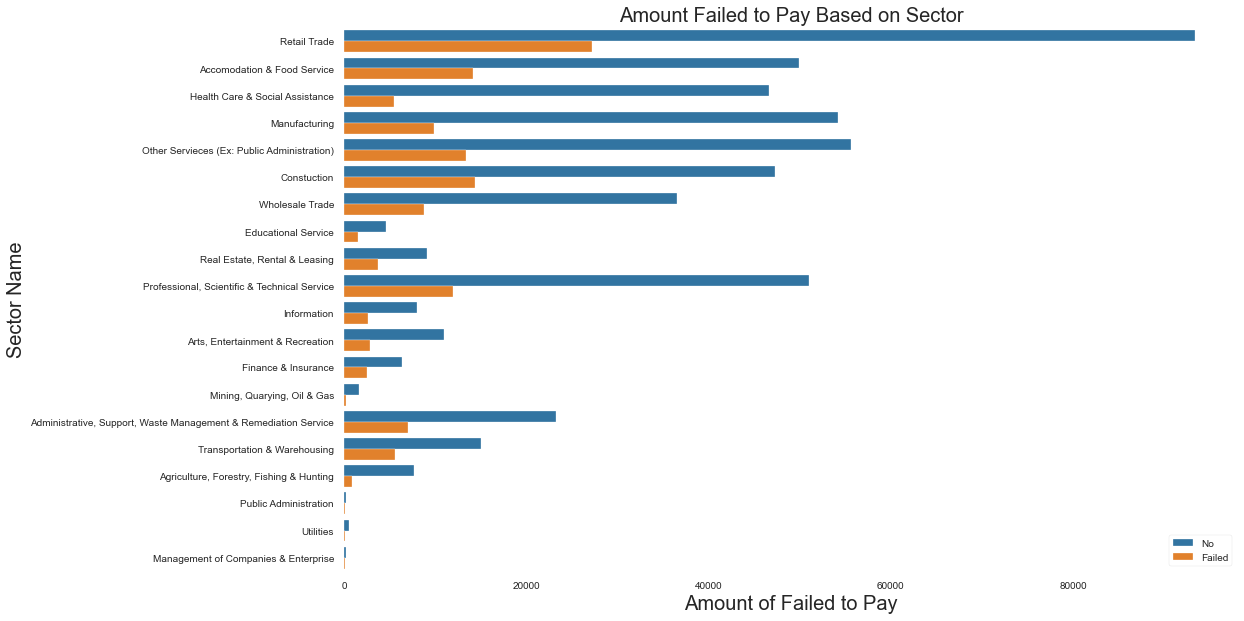

In [32]:
f, ax = plt.subplots(figsize=(16,10))

sns.countplot(y = "Sector_name", hue = "MIS_Status", data = SBAdata)

plt.title('Amount Failed to Pay Based on Sector', fontsize=20)

plt.xlabel('Amount of Failed to Pay', fontsize=20)
plt.ylabel('Sector Name', fontsize=20)

plt.legend(["No", "Failed"],loc='lower right')

plt.show()

In [33]:
pd.DataFrame(SBAdata.groupby('Sector_name')['MIS_Status'].value_counts()).unstack(
    level = 1
).style.highlight_max(color='yellow').highlight_min(color='violet')

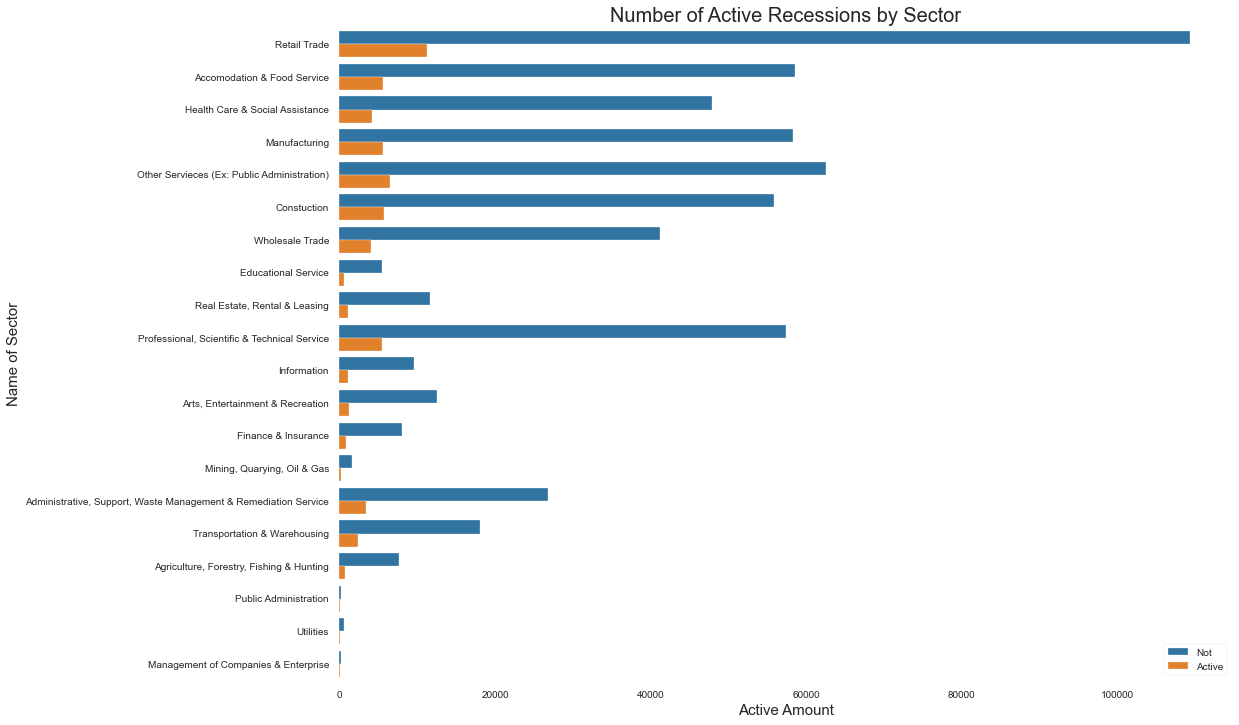

In [34]:
f, ax = plt.subplots(figsize=(16,12))

sns.countplot(y = "Sector_name", 
              hue = "Recession", data = SBAdata)

plt.title('Number of Active Recessions by Sector', fontsize = 20)

plt.xlabel('Active Amount', fontsize = 15)
plt.ylabel('Name of Sector', fontsize = 15)

plt.legend(["Not", "Active"],loc = 'lower right')
plt.show()

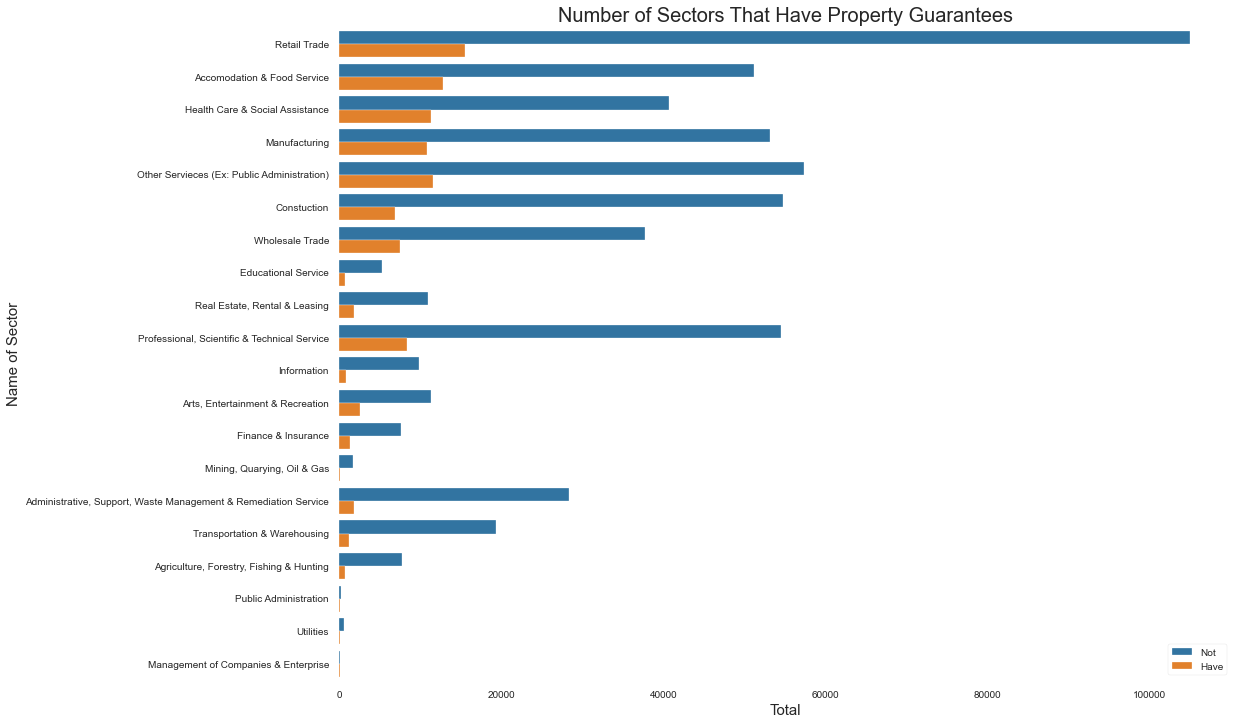

In [35]:
f, ax = plt.subplots(figsize=(16,12))

sns.countplot(y = "Sector_name", hue = "RealEstate", data = SBAdata)

plt.title('Number of Sectors That Have Property Guarantees', fontsize=20)

plt.xlabel('Total', fontsize=15)
plt.ylabel('Name of Sector', fontsize=15)

plt.legend(["Not", "Have"],loc='lower right')
plt.show()

In [36]:
pd.DataFrame(SBAdata.groupby('Sector_name')[
    'RealEstate'
].value_counts()).unstack(
    level = 1
).style.highlight_max(color='yellow').highlight_min(color='violet')

In [37]:
SBAdata['Term'].describe()

count    653377.000000
mean        104.191121
std          75.404780
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

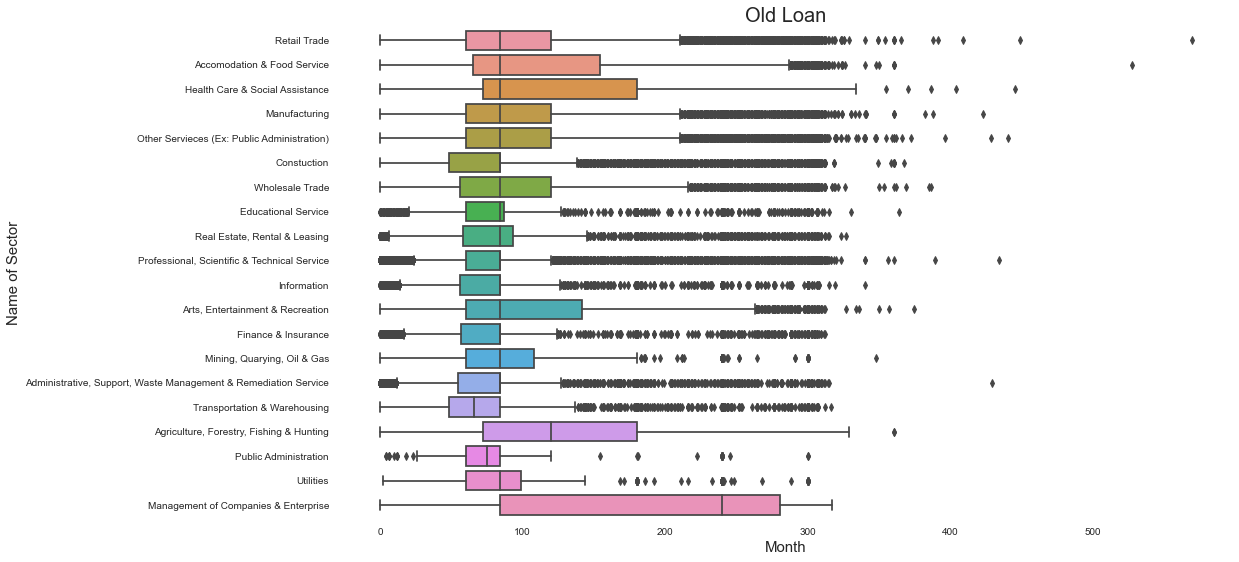

In [38]:
f, ax = plt.subplots(figsize=(16,9))

sns.boxplot(x = "Term", y = "Sector_name", data = SBAdata)

plt.title('Old Loan', fontsize=20)

plt.xlabel('Month', fontsize=15)
plt.ylabel('Name of Sector', fontsize=15)

plt.show()

In [39]:
SBAdata.groupby('Sector_name')[
    'Term'
].describe().style.highlight_max(color = 'yellow').highlight_min(color = 'violet')

,count,mean,std,min,25%,50%,75%,max
Sector_name,,,,,,,,
Accomodation & Food Service,64059.000000,120.668930,80.004442,0.000000,65.000000,84.000000,154.000000,527.000000
"Administrative, Support, Waste Management & Remediation Service",30189.000000,81.668687,55.197328,0.000000,55.000000,84.000000,84.000000,429.000000
"Agriculture, Forestry, Fishing & Hunting",8404.000000,119.735245,65.941232,0.000000,72.000000,120.000000,180.000000,360.000000
"Arts, Entertainment & Recreation",13808.000000,114.865151,77.241950,0.000000,60.000000,84.000000,141.250000,374.000000
Constuction,61622.000000,88.453848,71.232112,0.000000,48.000000,84.000000,84.000000,367.000000
Educational Service,5957.000000,95.106094,68.127575,0.000000,60.000000,84.000000,87.000000,364.000000
Finance & Insurance,8843.000000,97.702250,74.866735,0.000000,57.000000,84.000000,84.000000,312.000000
Health Care & Social Assistance,52021.000000,124.771438,82.270722,0.000000,72.000000,84.000000,180.000000,445.000000
Information,10634.000000,85.161275,60.284219,0.000000,56.000000,84.000000,84.000000,340.000000


In [40]:
pd.DataFrame(SBAdata.groupby('Sector_name')[
    'Is_CreatedJob'
].value_counts()).unstack(level=1).style.highlight_max(color = 'yellow').highlight_min(color = 'violet')

In [41]:
pd.DataFrame(SBAdata.groupby('Sector_name')[
    'NewExist'
].value_counts()).unstack(level = 1).style.highlight_max(color = 'yellow').highlight_min(color = 'violet')

___

### **2.4 Feature Selection**

At this step, we are selecting for which features are more relevant to our target than others.

___

In [42]:
SBAdata = SBAdata.drop(axis =1, columns = ['LoanNr_ChkDgt','City','State', 'Zip', 'UrbanRural', 'LowDoc',
                                    'ApprovalDate', 'ApprovalFY', 'SBA_Appv','DisbursementDate', 
                                     'Sector_name','BalanceGross', 'ChgOffPrinGr'])

In [43]:
SBAdata['DisbursementGross'] = np.log(SBAdata['DisbursementGross'])

outliers1_drop = SBAdata[(SBAdata['DisbursementGross'] > 14.9)].index
SBAdata.drop(outliers1_drop, inplace=True)

SBAdata['GrAppv'] = np.log(SBAdata['GrAppv'])

outliers2_drop = SBAdata[(SBAdata['GrAppv'] < 7.5)].index
SBAdata.drop(outliers2_drop, inplace=True)

wrong_input = SBAdata[(SBAdata['NoEmp'] == 0)].index
SBAdata.drop(wrong_input, inplace=True)

SBAdata['NoEmp']= stats.boxcox(SBAdata['NoEmp'])[0]

outliers3_drop = SBAdata[(SBAdata['NoEmp'] > 3.3)].index
SBAdata.drop(outliers3_drop, inplace=True)

wrong_input_2 = SBAdata[(SBAdata['Term'] < 75)].index
wrong_input_3 = SBAdata[(SBAdata['Term'] > 276)].index
SBAdata.drop(wrong_input_2, inplace=True)
SBAdata.drop(wrong_input_3, inplace=True)

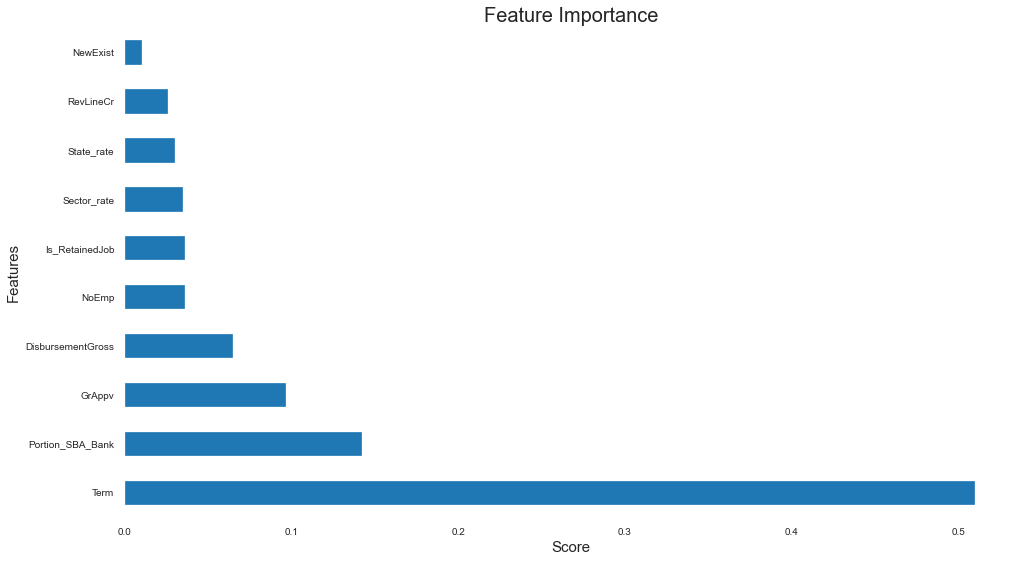

In [44]:
y = SBAdata['MIS_Status']
X = SBAdata.drop(columns=['MIS_Status'], axis=1)


model = XGBClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index = X.columns)

f, ax = plt.subplots(figsize = (16,9))

feat_importances.nlargest(10).plot(kind = 'barh')

plt.title('Feature Importance', fontsize = 20)
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Score', fontsize = 15)

plt.show()

It can be seen that following are top 3 variables that have an impact on our target variable:

>1. Term (Loan Length)

>2. Portion_SBA_Bank

>3. GrAppv


In [45]:
SBAdata = SBAdata[['RevLineCr', 'Term', 'Portion_SBA_Bank', 'GrAppv', 'State_rate', 'DisbursementGross',
            'Is_RetainedJob', 'Sector_rate', 'Recession', 'Is_CreatedJob', 'MIS_Status']]
SBAdata.shape

(378578, 11)

___

### **2.5 Pre-Modeling data preparation**
 
___

In [46]:
y = SBAdata['MIS_Status']
X = SBAdata.drop(columns=['MIS_Status'], axis = 1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size = 0.25, 
    random_state = 27, 
    stratify = y)

In [48]:
over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train, y_train = pipeline.fit_resample(X_train, y_train)

___
## **3. MODELLING**

Once all the data is cleaned, it is ready to be entered into the model. Here we evaluate which model is more optimal.

___

In [49]:
def model_evaluation(algo,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_train_ypred = algo.predict(X_train)
    y_train_prob = algo.predict_proba(X_train)[:,-1]

    y_test_ypred = algo.predict(X_test)
    y_test_prob = algo.predict_proba(X_test)[:,-1]
    y_probas = algo.predict_proba(X_test)
    
    # Confussion Matrix
    
    plot_confusion_matrix(algo, X_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    # ROC Curve
    
    skplt.metrics.plot_roc(y_test, y_probas,figsize=(16,9))

___
### Logistic Regression

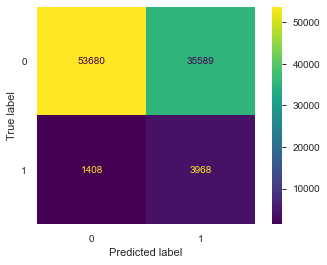

Classification Report: 
               precision    recall  f1-score   support

           0      0.974     0.601     0.744     89269
           1      0.100     0.738     0.177      5376

    accuracy                          0.609     94645
   macro avg      0.537     0.670     0.460     94645
weighted avg      0.925     0.609     0.711     94645



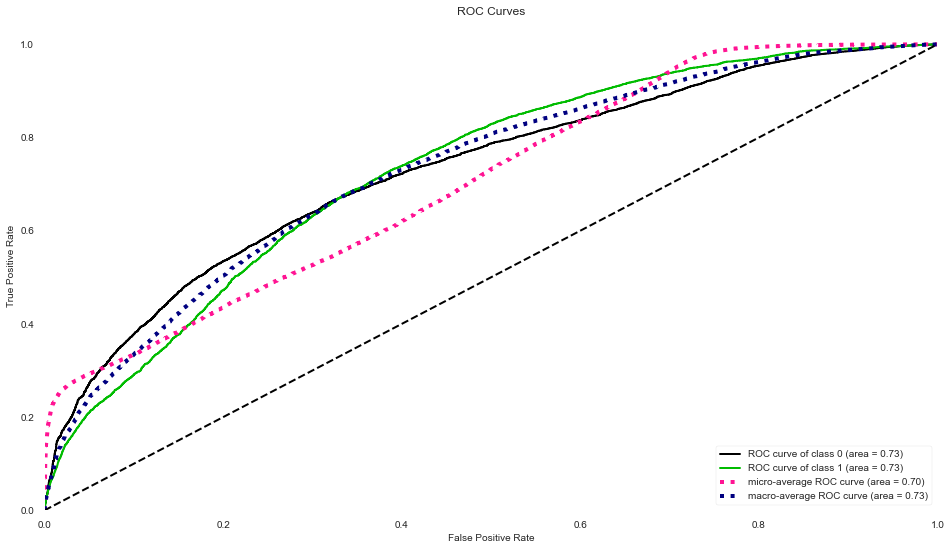

In [50]:
lr = LogisticRegression()

model_evaluation(lr,X_train,y_train,X_test,y_test)

___
### Naivye Bayes

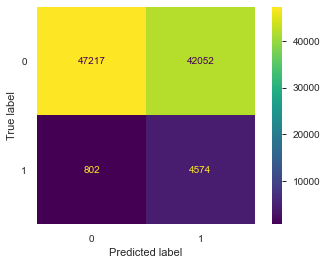

Classification Report: 
               precision    recall  f1-score   support

           0      0.983     0.529     0.688     89269
           1      0.098     0.851     0.176      5376

    accuracy                          0.547     94645
   macro avg      0.541     0.690     0.432     94645
weighted avg      0.933     0.547     0.659     94645



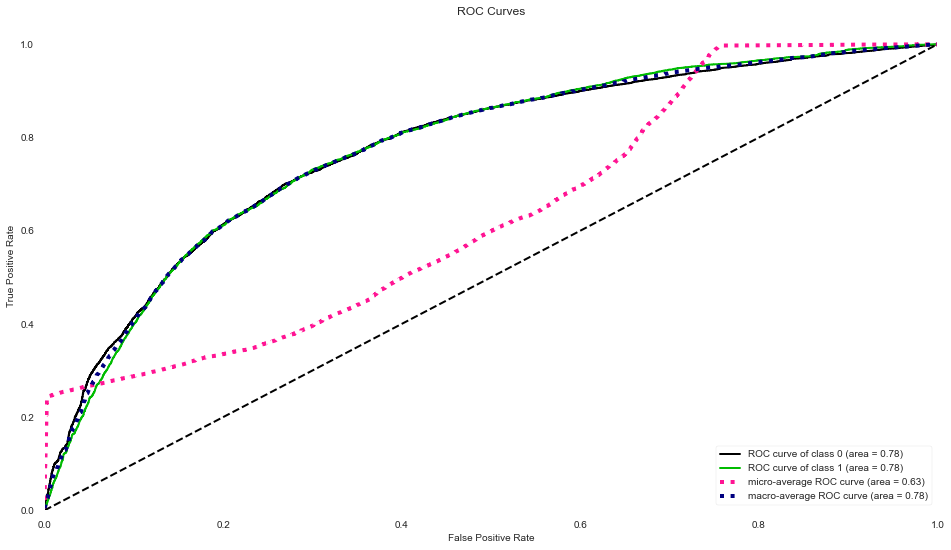

In [51]:
NB = GaussianNB()
model_evaluation(NB, X_train, y_train, X_test, y_test)

____
### KNN

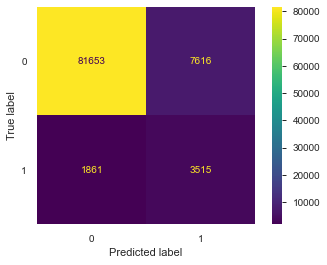

Classification Report: 
               precision    recall  f1-score   support

           0      0.978     0.915     0.945     89269
           1      0.316     0.654     0.426      5376

    accuracy                          0.900     94645
   macro avg      0.647     0.784     0.686     94645
weighted avg      0.940     0.900     0.916     94645



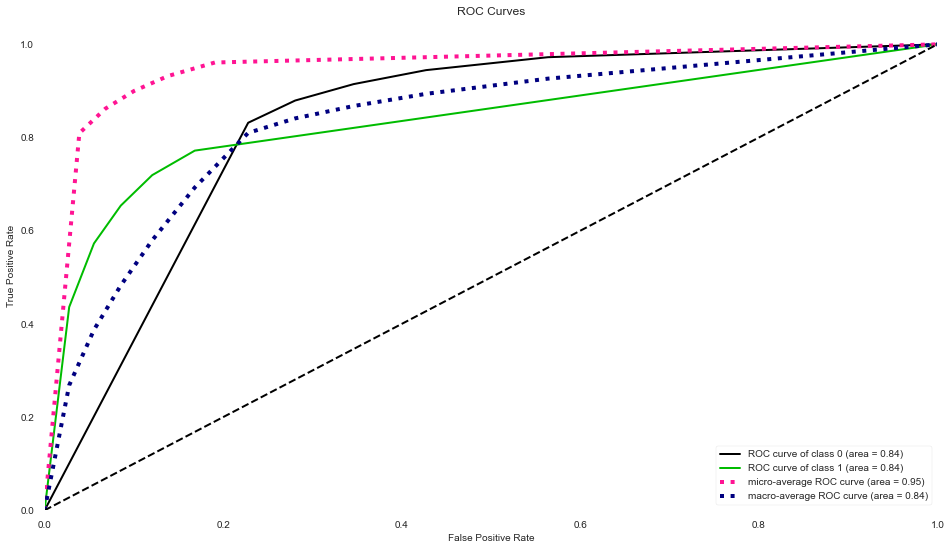

In [52]:
knn = KNeighborsClassifier()
model_evaluation(knn, X_train, y_train, X_test, y_test)

___
### Random Forest

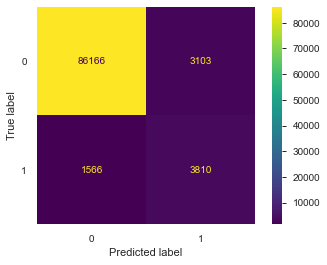

Classification Report: 
               precision    recall  f1-score   support

           0      0.982     0.965     0.974     89269
           1      0.551     0.709     0.620      5376

    accuracy                          0.951     94645
   macro avg      0.767     0.837     0.797     94645
weighted avg      0.958     0.951     0.954     94645



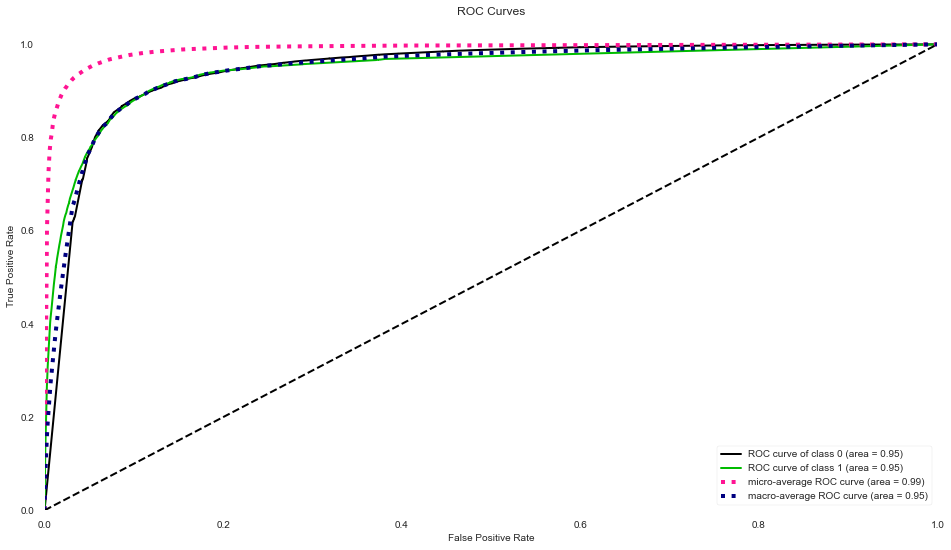

In [53]:
rf = RandomForestClassifier()
model_evaluation(rf, X_train, y_train, X_test, y_test)

___
### XGBoost Classifier

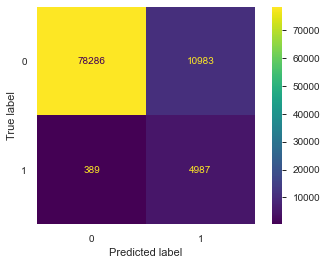

Classification Report: 
               precision    recall  f1-score   support

           0      0.995     0.877     0.932     89269
           1      0.312     0.928     0.467      5376

    accuracy                          0.880     94645
   macro avg      0.654     0.902     0.700     94645
weighted avg      0.956     0.880     0.906     94645



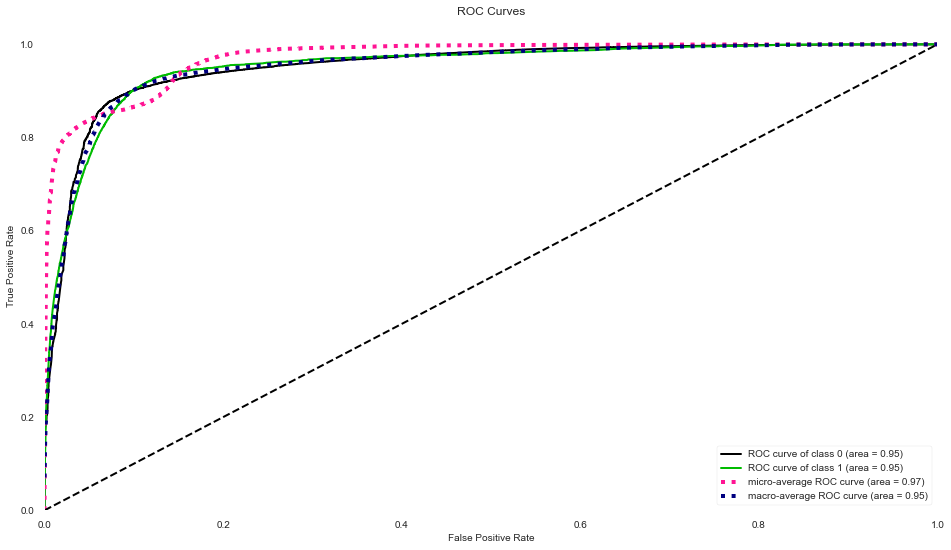

In [54]:
xgb = XGBClassifier()
model_evaluation(xgb, X_train, y_train, X_test, y_test)

___
## **4. MODEL TUNNING**

From all the above models, we can conclude that XGBoost is the best.

___

In [55]:
def optimal_model(clf, params,X_train,y_train,X_test,y_test ):
    
    search = GridSearchCV(estimator=clf,
                          param_grid=params,
                          scoring = 'f1',
                          n_jobs = -1,
                          cv = 3,
                          verbose=True)

    
    search.fit(X_train, y_train)
    
    best = search.best_estimator_
    best_model = best.fit(X_train, y_train)

    y_test_ypred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:,-1]
    y_probas = best_model.predict_proba(X_test)
    
    print('Best parameters: \n',search.best_params_)
    print('='*70)
    
    
    #Confussion Matrix
    
    plot_confusion_matrix(algo, X_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    
    # ROC Curve

    skplt.metrics.plot_roc(y_test, y_probas,figsize=(16,9) )
    

In [ ]:
params ={"learning_rate"    : [0.05, 0.10, 0.15] ,
         "max_depth"        : [ 3, 4, 5, 6],
         "min_child_weight" : [ 1, 3, 5, 7 ],
         "gamma"            : [ 0.0, 0.1, 0.2 ],
         "colsample_bytree" : [ 0.3, 0.4, 0.5] }


{'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 1}


xgb = XGBClassifier(base_score = 0.5, booster = 'gbtree', 
                    colsample_bylevel = 1, colsample_bynode = 1, 
                    colsample_bytree = 0.5, gamma = 0.0,
                    learning_rate = 0.15, max_delta_step = 0, 
                    max_depth = 6, min_child_weight = 1, 
                    missing = None, n_estimators = 150, 
                    n_jobs = 1, nthread = None, objective ='binary:logistic',
                    reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, 
                    subsample = 1, verbosity = 1)

optimal_model(xgb, params, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 23.8min


___

## **5. Conclusion**

There will always be a trade-off between Recall and Precision, so we are using F1- Score on GridScearchCV because it will take the harmonic mean of Precision and Recall.


The best model is XGBoost:

- AUC 98.9%, 


- Recall 85.1%,


- Precission 51%

___